## Easy MLP / Fully Connected / Vanilla Network Tensorflow Example
### Motivation
When looking in the internet for examples to learn Tensorflow, the only good example I found was the Mnist-tutorial. The problem with it is that, when you know nothing, to start with a proyect that takes ages to train and that involves multiple kinds of layers does not help. As a consequence, I made this example to get into the Tensorflow world, being a lot simpler and faster to train.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

/home/lucas/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Introduction

The aim of this notebook is to show how a simple MLP is implemented by solving a simple classification example.

### Triangular Classifier
The problem to solve is to tell whether random bidimentional values ((x,y) pairs between -0.5 and 0.5) lie inside a triangular shape (with vertices in (0.,0.5),(0.,-0.5),(-0.5,0.) and (0.5,0.)) or not.

### Code : Generating the values & datasets

Random (x,y) point taken from features : [-0.31391088  0.49070846]
Does it lie inside the triangle? : False


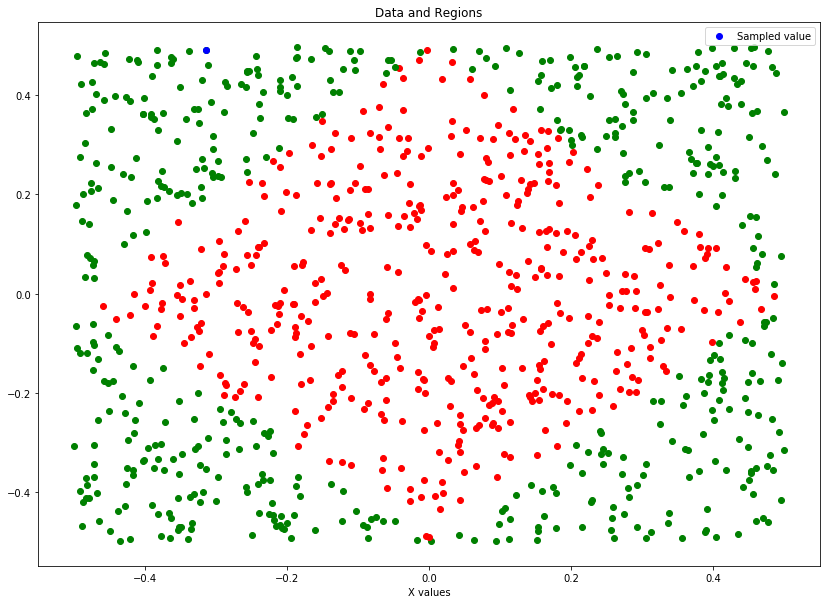

In [59]:
# Data Generator
N_items = 1000
features = np.random.random((N_items,2)) - 0.5 
labels = (features[:,1]-(abs(features[:,0]) - 0.5) > 0) & (features[:,1] - (0.5 - abs(features[:,0])) < 0) 

sample = np.random.randint(0,N_items)
print('Random (x,y) point taken from features : %s' % str(features[sample]))
print('Does it lie inside the triangle? : %s' % str(labels[sample]))

plt.figure(figsize=(14,10))
for i in range(len(features)):
    if(labels[i]):
        plt.plot(features[i][0],features[i][1],'o',color='r')
    else:
        plt.plot(features[i][0],features[i][1],'o',color='g')
plt.plot(features[sample][0],features[sample][1],'o',color='b',label='Sampled value')
plt.legend()
plt.title('Data and Regions')
plt.xlabel('X values')
plt.show('Y values')

# Datasets
train_test_rel = 3/4

train_data = features[1:int(N_items*train_test_rel)]
train_labels = np.array([float(a) for a in labels[1:int(N_items*train_test_rel)]])

test_data = features[int(N_items*train_test_rel):]
test_labels = np.array([ float(a) for a in labels[int(N_items*train_test_rel):]])

## Neural network modeling
Now its time to build up our network!
### Considerations
- Units are the number of neurons
- Don't forget the input and ouput layers
- Remember to connect the layers with "input"
- Logits layers is the number of classes your features have

In [136]:
def mlp_model(features):
    # Input Layer
    input_shape = features
    # Dense Layer 1
    dense_1 = tf.layers.dense(inputs=input_shape, units=50, activation=tf.nn.relu)
    # Dense Layer 2
    dense_2 = tf.layers.dense(inputs=dense_1, units=25, activation=tf.nn.relu)
    # Dense Layer 3
    dense_3 = tf.layers.dense(inputs=dense_2, units=10, activation=tf.nn.relu)
    # Ouput Layer
    logits = tf.layers.dense(inputs=dense_3, units=2, activation=tf.nn.softmax)
    
    return logits 

## Setting things up for the estimator
The estimator is a tensorflow object that mainly allows to:
- PREDICT
- TRAIN
- EVAL

To make use of all this, we first need to build up a function that suits the estimator. 
### What does the estimator need ?
- The network we created in the cell above
- An optimizer to train with
- A loss function to minimize
- How to evaluate the model
- What to return in a prediction

In [178]:
def model_for_estimator(features, labels, mode):
    logits = mlp_model(features)
    predictions = {
        "classes" : tf.argmax(input=logits, axis=1),
        "probabilities" : tf.nn.softmax(logits, name='softmax_tensor')
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    
    loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=tf.cast(labels, dtype=tf.int32))
    )
    
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metric_ops = {
            "accuracy": tf.metrics.accuracy(
                labels=labels, predictions=predictions["classes"])}
        return tf.estimator.EstimatorSpec(
            mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

    

In [170]:
# To make a neural network using tensorflow's estimator, we need to define it as a funcion
def simple_mlp_model(features, labels, mode): # It should receive 3 arguments
    # We start with the input layer : the features
    input_shape = features 
    # In this example we'll define 3 fully-connected layers with 50,25 and 10 neurons
    dense = tf.layers.dense(inputs=input_shape, units=50, activation=tf.nn.relu)
    dense2 = tf.layers.dense(inputs=dense, units=25, activation=tf.nn.relu)
    dense3 = tf.layers.dense(inputs=dense2, units=10, activation=tf.nn.relu)
    # As we have to deal with two classes, we need two neurons at the ouput layer
    logits = tf.layers.dense(inputs=dense3, units=2, activation=tf.nn.softmax)   
    # Now we have to wrap things up for the estimator. Fistly we define a predicition dict
    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    # We now prepare what is needed so as the PREDICT, TRAIN and EVAL mode work
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=logits, labels=tf.cast(labels, dtype=tf.int32)))

  # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

## Training, Evaluating and Predicting with our model

In [179]:
## To start with, we create the estimator
triangle_classifier = tf.estimator.Estimator(
    model_fn=model_for_estimator, model_dir="/tmp/triangle_model"
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/triangle_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f90b6777a58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [180]:
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
     tensors=tensors_to_log, every_n_iter=50)

In [181]:
## Now it's time to train it !
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=train_data,
    y=train_labels,
    batch_size=128,
    num_epochs=None,
    shuffle=True
)

triangle_classifier.train(
    input_fn=train_input_fn,
    steps=1000
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/triangle_model/model.ckpt.
INFO:tensorflow:loss = 0.6903071485413701, step = 1
INFO:tensorflow:global_step/sec: 472.315
INFO:tensorflow:loss = 0.6768616992068563, step = 101 (0.213 sec)
INFO:tensorflow:global_step/sec: 573.392
INFO:tensorflow:loss = 0.6610040483675168, step = 201 (0.174 sec)
INFO:tensorflow:global_step/sec: 517.5
INFO:tensorflow:loss = 0.623399910936425, step = 301 (0.196 sec)
INFO:tensorflow:global_step/sec: 539.283
INFO:tensorflow:loss = 0.5501382868674476, step = 401 (0.183 sec)
INFO:tensorflow:global_step/sec: 556.527
INFO:tensorflow:loss = 0.46709967483688286, step = 501 (0.181 sec)
INFO:tensorflow:global_step/sec: 572.288
INFO:tensorflow:loss = 0.4189295657948453, step = 601 (0.17

In [182]:
## Evaluation
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=test_data,
    y=test_labels,
    num_epochs=1,
    shuffle=False)
eval_results = triangle_classifier.evaluate(input_fn=eval_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-23-14:20:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/triangle_model/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-23-14:20:23
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.976, global_step = 1000, loss = 0.35782486


In [186]:
## Prediction
# I usually don't believe in the results of a network just by looking at the high accuracy obtained
# So I like tesing predictions with my own examples and check how the model responds

       [[0.5,0.5], # Clearly outside
       [0.,0.], # Clearly inside
       [-0.4,0.11], # Close to the edge, but outside
       [0.3,0.19], # Close to the edge, but inside
       ])

predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=mini_test_features,
    shuffle=False
    
)

results = triangle_classifier.predict(input_fn=predict_input_fn)
list(results)




INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/triangle_model/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'classes': 0, 'probabilities': array([0.73105857, 0.26894143])},
 {'classes': 1, 'probabilities': array([0.27052907, 0.72947093])},
 {'classes': 0, 'probabilities': array([0.64588736, 0.35411264])},
 {'classes': 1, 'probabilities': array([0.45181278, 0.54818722])}]

## Conclusion 
As we can observe, the results obtained with predict are accurate. In fact, an interesting detail is that the max probability in the first two cases is higher than in the third and the fourth case, as the last two are closer to the edge of the delimiter region, and so, are more difficult to classify correctly 